## Forked from belows:
* [[Inference] EfficientDet](https://www.kaggle.com/shonenkov/inference-efficientdet)
* [[WBF over TTA][Single Model] EfficientDet](https://www.kaggle.com/shonenkov/bayesian-optimization-wbf-efficientdet)

In [1]:
!pip install --no-deps '../input/packageefficientnet/timm-0.1.30-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/packageefficientnet/pycocotools-2.0.1-cp37-cp37m-linux_x86_64.whl' > /dev/null
!pip install --no-deps '../input/packageefficientnet/omegaconf-2.0.0-py3-none-any.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, '../input/efficientdetrwightman')
sys.path.insert(0, '../input/weightedboxesfusion')

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
# Global Parameters
IMG_SIZE_ORG = 1024
img_size_global = 1024
weight_global = '../input/efficientdetweights/1024-fold0-50.bin'
test_test = True

# Import test data

In [4]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=img_size_global, width=img_size_global, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [5]:
if test_test:
    DATA_ROOT_PATH = '../input/global-wheat-detection/test'
else:
    DATA_ROOT_PATH = '../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

# Load network

In [7]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=img_size_global
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net, config)
    net.eval();
    return net.cuda()

net = load_net(weight_global)

# Prepare test time augmentation

In [8]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = img_size_global

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes, scores):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes, scores

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes, scores):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes, scores
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes, scores):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes, scores
    
class TTAColorFlip(BaseWheatTTA):
    def augment(self, image):
        return image.flip(0)
    
    def batch_augment(self, images):
        return images.flip(1)
    
    def deaugment_boxes(self, boxes, scores):
        return boxes, scores
    
class TTACrop(BaseWheatTTA):
    def __init__(self, size, loc, boundary=0.5):
        self.size = size
        self.pad = (img_size_global - self.size) // 2
        self.size = img_size_global - (2*self.pad)
        self.boundary = boundary
        self.loc = loc
    
    def augment(self, image):
        if self.loc == 0: # center
            image = image[:, self.pad:self.pad+self.size, self.pad:self.pad+self.size]
        elif self.loc == 1: # top-left
            image = image[:, 0:self.size, 0:self.size]
        elif self.loc == 2: # top-right
            image = image[:, 0:self.size, (self.pad*2):(self.pad*2+self.size)]
        elif self.loc == 3: # bottom-left
            image = image[:, (self.pad*2):(self.pad*2+self.size), 0:self.size]
        else: # bottom-right
            image = image[:, (self.pad*2):(self.pad*2+self.size), (self.pad*2):(self.pad*2+self.size)]
        
        image = cv2.resize(image.permute(1,2,0).cpu().numpy(), (img_size_global,img_size_global), interpolation=cv2.INTER_LINEAR)
        return torch.from_numpy(image).permute(2,0,1)
    
    def batch_augment(self, images):
        images = torch.stack([self.augment(image) for image in images])
        return images.cuda()
    
    def deaugment_boxes(self, boxes, scores):
        if scores is None:
            scores = np.random.rand(boxes.shape[0])
        
        box_score = np.concatenate((boxes, np.expand_dims(scores, axis=1)), axis=1)
        if self.loc == 0 or self.loc == 2 or self.loc == 4: # min x1
            box_score = box_score[np.min(box_score[:,0:1], axis=1) > 0+self.boundary]
        if self.loc == 0 or self.loc == 3 or self.loc == 4: # min y1
            box_score = box_score[np.min(box_score[:,1:2], axis=1) > 0+self.boundary]
        if self.loc == 0 or self.loc == 1 or self.loc == 3: # max x2
            box_score = box_score[np.max(box_score[:,2:3], axis=1) < img_size_global-1-self.boundary]
        if self.loc == 0 or self.loc == 1 or self.loc == 2: # max y2
            box_score = box_score[np.max(box_score[:,3:4], axis=1) < img_size_global-1-self.boundary]
        
        #box_score = box_score[np.min(box_score[:,0:4], axis=1) > 0+self.boundary]
        #box_score = box_score[np.max(box_score[:,0:4], axis=1) < img_size_global-1-self.boundary]
        
        boxes, scores = box_score[:,0:4], box_score[:,4]
        boxes = (boxes*(self.size/img_size_global))# + self.pad
        
        if self.loc == 0:
            boxes += self.pad
        else:
            if self.loc == 2 or self.loc == 4:
                boxes[:,0] += (2*self.pad)
                boxes[:,2] += (2*self.pad)
            if self.loc == 3 or self.loc == 4:
                boxes[:,1] += (2*self.pad)
                boxes[:,3] += (2*self.pad)
        return boxes, scores
    
class TTACenterReduce(BaseWheatTTA):
    def __init__(self, size):
        self.size = size
        self.pad = (img_size_global - self.size) // 2
        self.size = img_size_global - (2*self.pad)
        #self.boundary = 0.5
    
    def augment(self, image):
        image_out = torch.zeros(image.shape)
        image = cv2.resize(image.permute(1,2,0).cpu().numpy(), (self.size,self.size), interpolation=cv2.INTER_LINEAR)
        image = torch.from_numpy(image).permute(2,0,1)        
        image_out[:, self.pad:self.pad+self.size, self.pad:self.pad+self.size] = image
        return image_out
    
    def batch_augment(self, images):
        images = torch.stack([self.augment(image) for image in images])
        return images.cuda()
    
    def deaugment_boxes(self, boxes, scores):
        if scores is None:
            scores = np.random.rand(boxes.shape[0])
        boxes = ((boxes - self.pad)*img_size_global/self.size).clip(min=0, max=img_size_global)

        box_score = np.concatenate((boxes, np.expand_dims(scores, axis=1)), axis=1)
        box_score = box_score[np.min(box_score[:,2:4]-box_score[:,0:2], axis=1) > 0]
        box_score = box_score[np.max(box_score[:,2:4]-box_score[:,0:2], axis=1) <= img_size_global]
        
        boxes, scores = box_score[:,0:4], box_score[:,4]        
        return boxes, scores

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes, scores=None):
        for transform in self.transforms[::-1]:
            boxes, scores = transform.deaugment_boxes(boxes, scores)
        return self.prepare_boxes(boxes), scores

In [9]:
def process_det(index, det, score_threshold=0.25):
    boxes = det[index].detach().cpu().numpy()[:,:4]    
    scores = det[index].detach().cpu().numpy()[:,4]
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    boxes = (boxes).clip(min=0, max=img_size_global).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]

    return boxes, scores

# Test codes for TTA

torch.Size([3, 1024, 1024])


/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


torch.Size([3, 1024, 1024])


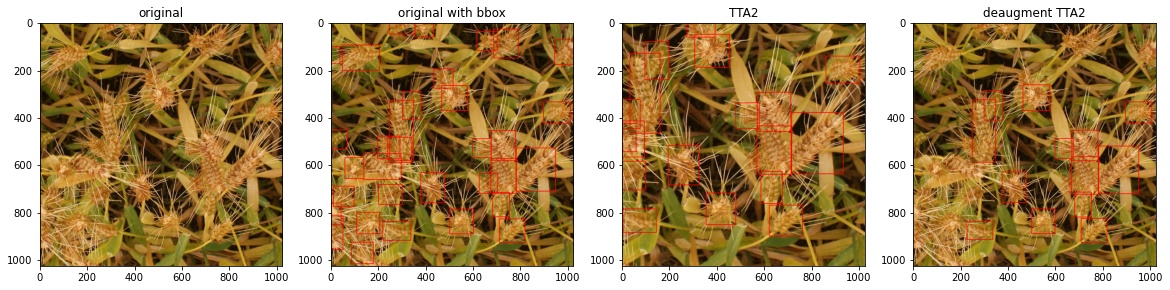

In [10]:
transform = TTACompose([
    #TTARotate90(),
    #TTAVerticalFlip(),
    #TTAResize(),
])
transform2 = TTACompose([
    #TTAHorizontalFlip(),
    #TTAVerticalFlip(),
    #TTARotate90(),
    TTACrop(size=800, loc=4, boundary=0.5),
])

fig, ax = plt.subplots(1, 4, figsize=(20, 8))

# original
image, image_id = dataset[1]
numpy_image = image.permute(1,2,0).cpu().numpy().copy()
ax[0].imshow(numpy_image);
ax[0].set_title('original')

# tta
tta_image = transform.augment(image)
print(tta_image.shape)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()
tta_image_size = torch.tensor([[tta_image.shape[1], tta_image.shape[2]]])

det = net(tta_image.unsqueeze(0).float().cuda(), torch.tensor([1]).float().cuda(), img_size=tta_image_size.float().cuda())
boxes, scores = process_det(0, det)
del det
gc.collect()
for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0].astype(int), box[1].astype(int)),
                                   (box[2].astype(int)-1, box[3].astype(int)-1), (1, 0, 0), 2)
ax[1].imshow(tta_image_numpy);
ax[1].set_title('original with bbox')

# tta2
tta_image = transform2.augment(image)
print(tta_image.shape)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()
tta_image_size = torch.tensor([[tta_image.shape[1], tta_image.shape[2]]])

det = net(tta_image.unsqueeze(0).float().cuda(), torch.tensor([1]).float().cuda(), img_size=tta_image_size.float().cuda())
boxes, scores = process_det(0, det)
del det
gc.collect()
for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0].astype(int), box[1].astype(int)),
                                   (box[2].astype(int)-1,  box[3].astype(int)-1), (1, 0, 0), 2)
ax[2].imshow(tta_image_numpy);
ax[2].set_title('TTA2')

# deaugment
boxes, _ = transform2.deaugment_boxes(boxes)
for box in boxes:
    cv2.rectangle(numpy_image, (box[0].astype(int), box[1].astype(int)),
                               (box[2].astype(int)-1, box[3].astype(int)-1), (1, 0, 0), 2)
ax[3].imshow(numpy_image);
ax[3].set_title('deaugment TTA2');

# Make TTA combination

In [11]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
                               #[TTACrop(size=400, loc=1), TTACrop(size=400, loc=2), TTACrop(size=400, loc=3), TTACrop(size=400, loc=4), None]):
    print([tta_transform for tta_transform in tta_combination if tta_transform])
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

[<__main__.TTAHorizontalFlip object at 0x7fac4804fbd0>, <__main__.TTAVerticalFlip object at 0x7fac4804ff50>, <__main__.TTARotate90 object at 0x7fac4804f910>]
[<__main__.TTAHorizontalFlip object at 0x7fac4804fbd0>, <__main__.TTAVerticalFlip object at 0x7fac4804ff50>]
[<__main__.TTAHorizontalFlip object at 0x7fac4804fbd0>, <__main__.TTARotate90 object at 0x7fac4804f910>]
[<__main__.TTAVerticalFlip object at 0x7fac4804ff50>, <__main__.TTARotate90 object at 0x7fac4804f910>]
[]


# Make prediction with TTA

In [12]:
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            #images_batch = tta_transform.batch_augment(images.clone())
            img_sizes = torch.stack((torch.ones([2,])*images.shape[2],
                                     torch.ones([2,])*images.shape[3])).permute(1,0)
            img_sizes = img_sizes.int().cuda()
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda(), img_size=img_sizes)

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                scores = scores[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes, scores = tta_transform.deaugment_boxes(boxes.copy(), scores.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores,
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=img_size_global, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/image_size).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]    
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size)
    return boxes, scores, labels

# Test codes for prediction

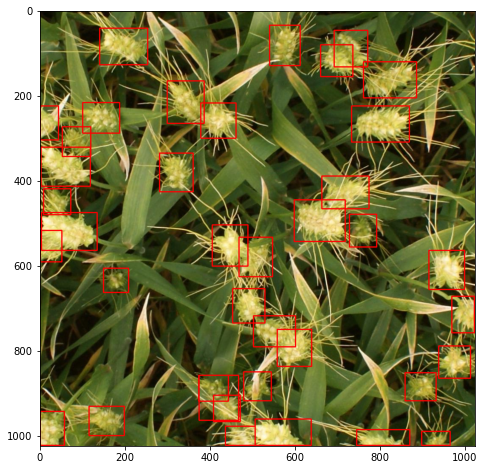

In [13]:
# Show sample result of TTA image
import matplotlib.pyplot as plt

sample_idx = 0 # 0-9
for j, (images, image_ids) in enumerate(data_loader):
    if sample_idx//2 == j:
        break
i = sample_idx%2

predictions = make_tta_predictions(images)
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=img_size_global)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2]-1, box[3]-1), (1, 0, 0), 2)
    
ax.imshow(sample);

# Predict and format for final submission

In [14]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [15]:
results = []

from tqdm import tqdm
for images, image_ids in tqdm(data_loader):
#for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*IMG_SIZE_ORG/img_size_global).astype(np.int32).clip(min=0, max=IMG_SIZE_ORG)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


In [16]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
print(test_df.shape)
test_df.head()

(10, 2)


,image_id,PredictionString
0,348a992bb,0.8480 733 223 137 86 0.8199 598 444 121 99 0....
1,796707dd7,0.8344 710 825 107 100 0.8157 502 784 98 105 0...
2,aac893a91,0.8493 562 535 118 184 0.8115 556 69 136 188 0...
3,f5a1f0358,0.8429 943 435 80 183 0.8411 690 206 111 89 0....
4,cb8d261a3,0.8544 22 866 79 142 0.8330 263 772 116 77 0.8...
